In [28]:
## Packages -----
cran_packages <- list(
    "Rcpp",
    "data.table",
    "microbenchmark",
    "ggplot2"
)
invisible(
    lapply(
        cran_packages,
        function(i) {
            if (!require(i, character.only = T)) {
                install.packages(i)
                library(i, character.only = T)
            } else {
                library(i, character.only = T)
            }
        }
    )
)
# Package containing a set of helper functions:
if (!require(fromScratchR)) {
    devtools::install_github("pat-alt/fromScratchR")
    library(fromScratchR)
} else {
    library(fromScratchR)
}

Loading required package: ggplot2



# Topic modelling - unsupervised learning

## Model and synthetic data

Consider the problem of classifying $d=[1,D]$ documents into one of two latent topics $z_d \in \{0,1 \}$. We will denote $\mathbf{y}_d = (\mathbf{y}_{d,1},...,\mathbf{y}_{d,n_d})$ as the $(2 \times n_d)$ word choice vector of document $d$. Let $\mathbf{x}_d$ some meta data. The word choice vector corresponding to document $d$ can be modelled as follows:

$$
\mathbf{y}_d | z_d \sim \text{Categorical}(\Pi_{z_d})
$$

....

In R categorical data can be simulated using `stats::rmultinom(n,1,p)`. But since we were asked not to rely on packages too much (and also as a little exercise) we have decided to code this up from scratch using inverse CDF transformation. In base R we could do the following:

In [20]:
binary_search_rightmost <- function(x, target) {
  x <- sort(x)
  n <- length(x)
  l <- 0
  r <- n
  while (l < r) {
    m <- floor((l+r)/2)
    if (x[m+1] > target) {
      r <- m
    } else {
      l <- m+1
    }
  }
  return(r+1)
}

sim_categorical <- function(n, prob) {
  k <- length(prob)
  # Normalise prob if necessary:
  if (sum(prob)!=1) {
    prob <- prob/sum(prob)
  }
  emp_cdf <- cumsum(prob)
  U <- runif(n)
  X <- vapply(
    1:n,
    function(i) {
      col <- rep(0,k)
      col[binary_search_rightmost(x=emp_cdf, target=U[i])] <- 1
      return(col)
    },
    rep(0,k)
  )
  return(X)
}

This scales quite poorly though, so in order to boost performance we decided to code this up in C++ and compile through `Rcpp` (see below):

In [27]:
src <- 
"NumericMatrix simCategorical(int n, NumericVector p) {
  int k = p.size();
  NumericMatrix mat(k, n);
  // Normalise prob if necessary:
  if (sum(p)!=1) {
    p = p/sum(p);
  }
  NumericVector emp_cdf = cumsum(p);
  NumericVector u = Rcpp::runif(n, 0, 1);
  // Matrix for 1-hot-encoding:
  for (int j = 0; j < n; j++) {
    // Perform binary search:
    int l = 0;
    int r = k;
    double target = u[j];
    while (l < r) {
      int m = floor((l+r)/2);
      if (emp_cdf[m] > target) {
        r = m;
      } else {
        l = m+1;
      }
    }
    mat(r,j) = 1;
  }
  return mat;
}"
Rcpp::cppFunction(src)
n <- 1e6
p <- c(0.5,0.1,0.4)
rowSums(simCategorical(n, p))/n

[1] 0.500536 0.099882 0.399582

Amazingly, as you can see from the benchmark below the compiled C++ code even outperforms the function from the `stats` package.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



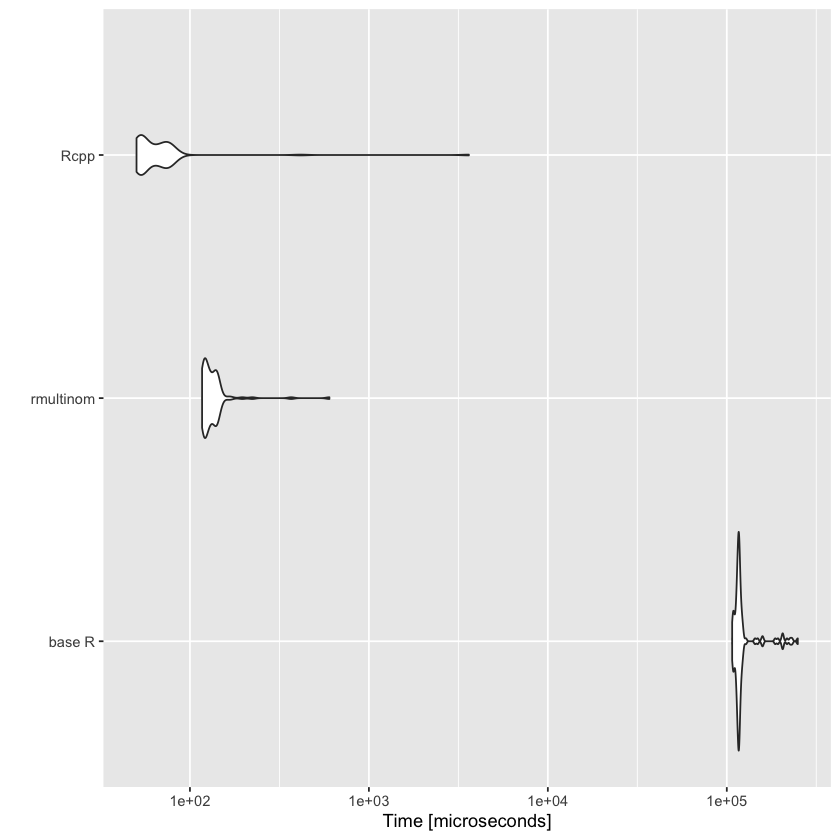

In [29]:
n <- 1000
mb <- microbenchmark(
    "base R" = {sim_categorical(n, p)},
    "rmultinom" = {rmultinom(n, 1, p)},
    "Rcpp" = {simCategorical(n, p)}
)
autoplot(mb)

## EM algorithm

## Numerical exercises

## Inference

## Real data